In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy
from statistics import mean
from scipy.ndimage import gaussian_filter
import seaborn as sns

C:\Users\Bruker\AppData\Local\Temp\ipykernel_31412\1988090634.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('Measured_temp_fluorescence.csv', sep=';')
df = df.apply(pd.to_numeric)
df

,Temperature,1,2,3,4,5,6.00
0,25.000,912.936,1564.63,3811.25,457.961,844.476,-251.107
1,25.100,1299.460,1822.48,3760.93,-174.556,732.489,-424.167
2,25.200,1120.150,1598.39,4067.84,361.848,781.729,-453.140
3,25.300,1966.550,2031.25,4673.55,817.620,1046.290,-120.641
4,25.400,1219.010,1184.05,4247.39,806.177,662.041,-630.780
...,...,...,...,...,...,...,...
734,98.428,9605.750,7337.92,14067.19,-259.995,-193.873,-1604.670
735,98.528,9072.850,7204.48,13499.65,-154.534,146.378,-1443.580
736,98.628,9566.020,7066.23,14117.86,-48.176,-194.588,-1131.440
737,98.728,9378.720,7904.92,13987.12,-908.245,-135.202,-523.156


In [3]:
temps = []
for t in df['Temperature']:
    temps.append(float(t))

In [8]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

In [5]:
def residuals(y_obs, y_fit):
    return y_obs - y_fit

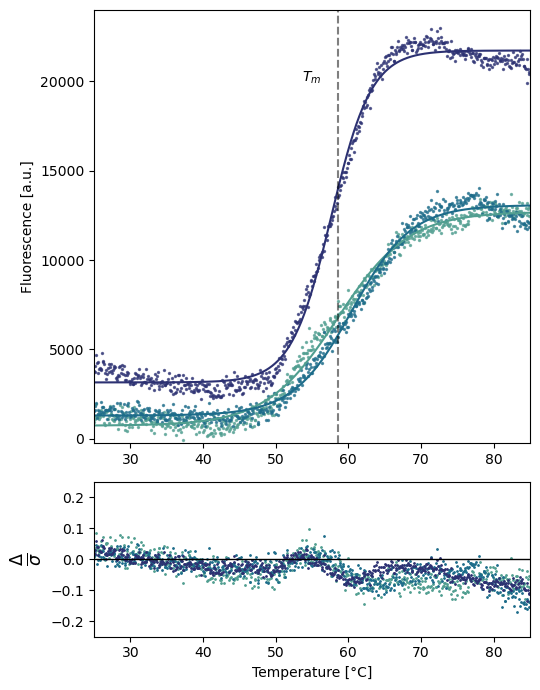

[57.712, 60.313, 57.712]
58.579+-0.7079025356643383


In [7]:
#Make nice plot of both data and residuals:

#cut off last part of dataset (after plateau)
df = df[df.Temperature <= 85]
temps = []
for t in df['Temperature']:
    temps.append(float(t))

#find residuals
def residuals(y_obs, y_fit):
    return y_obs - y_fit
    
#...and normalize them
def normalize(data):
    max_value = max(data)
    return np.array([x / max_value for x in data])

#define colors
linecolors=['#54a60d', '#299170', '#1e788c']
scattercolors=['#99c96f', '#7dc7ae', '#63b8c9']

scatter_cmap=sns.color_palette("crest", as_cmap=True)
line_cmap=sns.color_palette("crest", as_cmap=True)

#Plot:
fig = plt.figure(figsize=(5.5, 7))
gs = fig.add_gridspec(2, 1, height_ratios=[2.8, 1])
axs = gs.subplots()

inflection_points=[]
for i in range(1, len(df.columns)-3): #-3 to exclude negative controls
    d = df.iloc[:, i]
    d = d.to_numpy()
    p0 = [max(d), np.median(temps),1,min(d)] #initial values for the fit

    #curve fitting
    popt, pcov = curve_fit(sigmoid, temps, d, p0)
    fit = sigmoid(temps, *popt)

    dx = temps[1] - temps[0]
    d2_curve = np.gradient(np.gradient(fit, dx), dx)

    #inflection point
    infl = np.where(np.diff(np.sign(d2_curve)))[0][0]
    inflection_points.append(temps[infl])
    scatter_color=scatter_cmap(i/3)
    line_color=line_cmap(i/3)
    axs[0].scatter(temps, d, s=2, color=scatter_color, alpha=0.7)
    axs[0].plot(temps, fit, color=line_color, label='Parallel ' + str(i))

    #residuals
    axs[1].scatter(temps, residuals(normalize(d), normalize(fit)), s=1, color=scatter_color)
Tm_avg=mean(inflection_points)
axs[0].vlines(Tm_avg, -250, 24000, colors='k', linestyles='dashed', alpha=0.5)
axs[0].text(Tm_avg-5, 20000, '$T_m$')
axs[0].set_ylabel("Fluorescence [a.u.]")
axs[0].set_xlim(25, 85)
axs[0].set_ylim(-250, 24000)

axs[1].axhline(y=0, color="black", linewidth=1)
axs[1].set_xlabel("Temperature [°C]")
axs[1].set_ylabel(r'$\frac{\Delta}{\sigma}$', fontsize=18)
axs[1].set_ylim(-0.25, 0.25)
axs[1].set_xlim(25, 85)
plt.tight_layout()
plt.savefig("B22_Tm_plot.png", bbox_inches="tight",
            pad_inches=0.3, dpi=300)
plt.show()

#Find Tm for each measurement
print(inflection_points)

#Find Tm average and standard error
Tm_avg=mean(inflection_points)

stddev_Tm_avg = np.std(inflection_points)
n = len(inflection_points)
sem_Tm_avg = stddev_Tm_avg / np.sqrt(n)
print(f"{Tm_avg}+-{sem_Tm_avg}")

